In [6]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import random

import model as mdl
import agent as agt
import visualisation as vis
import sensitivity_analysis as sa
import batchrunner as bs
import warnings
import mesa.batchrunner as mbs
warnings.filterwarnings("ignore")

In [27]:
reload(mdl)
reload(agt)
reload(vis)
reload(bs)
reload(sa)

reload(mdl)
reload(agt)
reload(vis)
reload(bs)
reload(sa)

<module 'sensitivity_analysis' from '/home/reqctoe/CLS/10_ABM/agent-based-modelling/Project/sensitivity_analysis.py'>

In [ ]:
def save_datacollector(model):
    return model.datacollector

In [ ]:
# model = mdl.Forest
# params = {'harvest_volume':[50,170,300],
#           'harvest_nbrs':4, 
#           'harvest_prob':0.5, 
#           'fert_comp_ratio_exponent':-0.3, 
#           'top_n_sites_percent':[0.005,0.01,0.02]}

# outputs = ["Trees", "Fungi", "Living Trees Total Volume", "Harvested volume", "Infected Trees", "Mean Substrate", "Mean Soil Fertility"]

# n_replicates = 2
# data_collection_period = 1
# max_steps = 200

# # batch = sa.run_spec_params(model=model, params=params, outputs=outputs, n_max_timesteps=max_steps, n_replicates=n_replicates)
# test = mbs.batch_run(model,params,n_replicates, data_collection_period)
# # batch = mbs.batch_run(model,params,iterations,data_collection_period,max_steps)

# # var_params = [{'harvest_volume':50, 'top_n_sites_percent':0.005},
# #          {'harvest_volume':50, 'top_n_sites_percent':0.01},
# #          {'harvest_volume':50, 'top_n_sites_percent':0.02},
# #          {'harvest_volume':170, 'top_n_sites_percent':0.005},
# #          {'harvest_volume':170, 'top_n_sites_percent':0.01},
# #          {'harvest_volume':170, 'top_n_sites_percent':0.02},
# #          {'harvest_volume':300, 'top_n_sites_percent':0.005},
# #          {'harvest_volume':300, 'top_n_sites_percent':0.01},
# #          {'harvest_volume':300, 'top_n_sites_percent':0.02},]
# # fix_params = {'harvest_nbrs':4, 'harvest_prob':0.5, 'fert_comp_ratio_exponent':0.5}



# # model_reporter = {'datacollector':save_datacollector}
# # agent_reporter = {"Trees": lambda m: len(self.getall("Tree"))}
# # batchrun = bs.FixedBatchRunner(model, var_params, fix_params, iterations, max_steps, model_reporter)

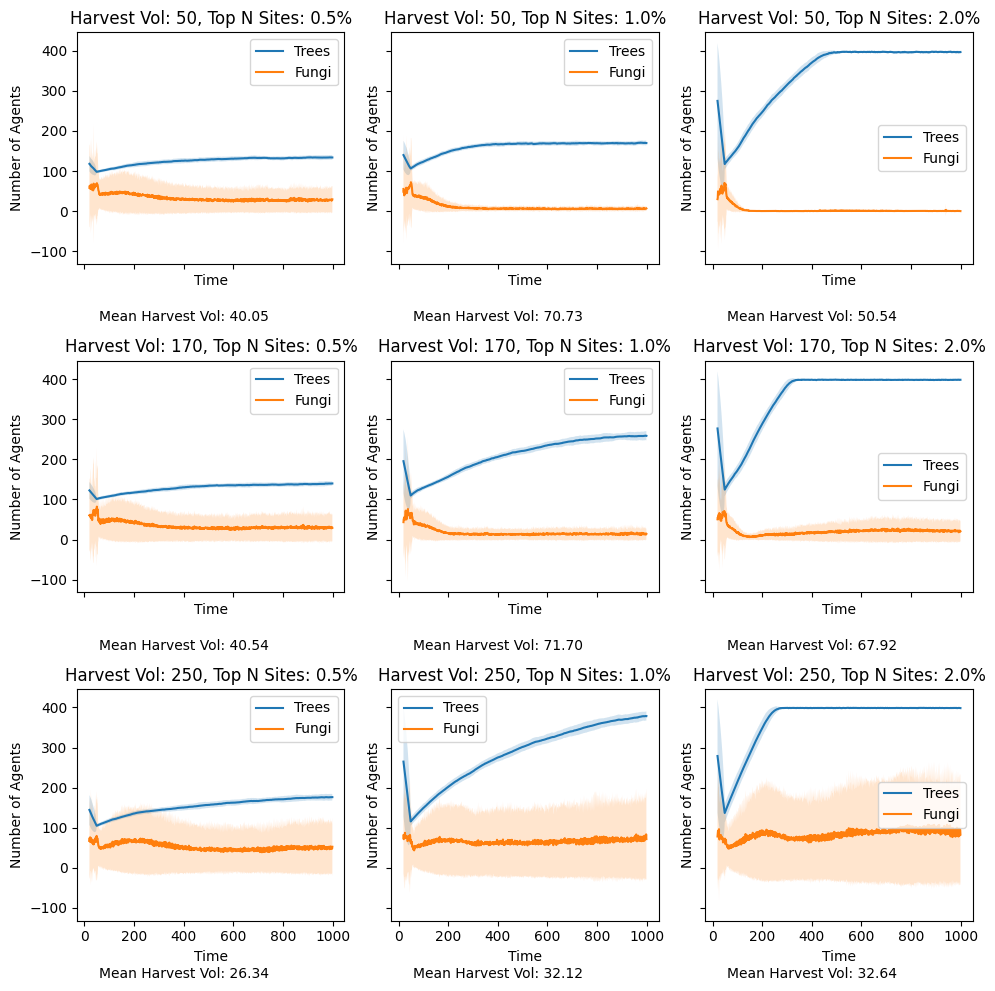

In [7]:
%matplotlib inline

width = 20
height = 20
n_init_trees = 100
n_init_fungi = 50
fert_comp_ratio_exponent = 0.5
top_n_sites_percent_values = [0.005, 0.01, 0.02]
harvest_volume_values = [50, 170, 250]
max_substrate=3
max_soil_fertility=1

n_runs = 50
n_steps = 1000
skip_frames = 20
seed = 37

np.random.seed(seed)
random.seed(seed)

# Initialize the model and run it for each combination of parameters
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

all_data = pd.DataFrame()

for i, top_n_sites_percent in enumerate(top_n_sites_percent_values):
    for j, harvest_volume in enumerate(harvest_volume_values):
        # Update the harvest parameters
        harvest_params = [harvest_volume, 4, 0.5]
        
        runs_data = pd.DataFrame()
        for k in range(n_runs):
            
            # Create and run the model
            model = mdl.Forest(width, height, n_init_trees, n_init_fungi, harvest_params, fert_comp_ratio_exponent, 
                            max_substrate, max_soil_fertility, top_n_sites_percent)        
            model.run_model(n_steps=n_steps)
            
            # Collect the data
            new_data = model.datacollector.get_model_vars_dataframe()
            new_data['Top N Sites Percent'] = top_n_sites_percent
            new_data['Harvest Volume'] = harvest_volume
            new_data['run_id'] = k
            
            runs_data = pd.concat([runs_data,new_data], ignore_index=True)
        
        # Calculate the mean and standard deviation of harvested volume
        harvested_volume_mean = new_data["Harvested volume"].mean()
        # harvested_volume_std = data["Harvested volume"].std()
        
        trees_runs = []
        fungi_runs = []
        
        # Plot each simulation run
        for l in range(n_runs):
            start_idx = l * n_steps + skip_frames
            end_idx = (l + 1) * n_steps
            param_data = runs_data.iloc[start_idx:end_idx].reset_index(drop=True)
            # Store Trees and Fungi data
            trees_runs.append(param_data['Trees'].values)
            fungi_runs.append(param_data['Fungi'].values)
        
        trees_runs = np.array(trees_runs)
        fungi_runs = np.array(fungi_runs)
        
        trees_mean = np.mean(trees_runs, axis=0)
        trees_std = np.std(trees_runs, axis=0)
        fungi_mean = np.mean(fungi_runs, axis=0)
        fungi_std = np.std(fungi_runs, axis=0)
        
        x_values = range(skip_frames, len(param_data)+skip_frames)
        axes[j,i].plot(x_values, trees_mean, label="Trees")
        axes[j,i].plot(x_values, fungi_mean, label="Fungi")
        
        axes[j,i].fill_between(x_values, trees_mean - trees_std, trees_mean + trees_std, alpha=0.2)
        axes[j,i].fill_between(x_values, fungi_mean - fungi_std, fungi_mean + fungi_std, alpha=0.2)

        # # Plot the data starting from the 50th time step
        ax = axes[j, i]
        ax.legend()
        ax.set_title(f'Harvest Vol: {harvest_volume}, Top N Sites: {top_n_sites_percent * 100}%')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Agents')
        
        # Print the mean and standard deviation below the plot
        textstr = '\n'.join((
            f'Mean Harvest Vol: {harvested_volume_mean:.2f}',
        ))
        ax.text(0.4, -0.2, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')

        all_data = pd.concat([all_data, runs_data], ignore_index=True)
        
plt.tight_layout()
plt.show()

# Write parquet file
table = pa.Table.from_pandas(all_data)
pq.write_table(table, f'param_experiments.parquet')

In [35]:
all_data

,Trees,Fungi,Living Trees Total Volume,Infected Trees,Mean Substrate,Substrate Variance,Mean Soil Fertility,Soil Fertility Variance,Harvested volume,Top N Sites Percent,Harvest Volume,run_id
0,100,50,13030,0,1.0875,0.654844,0.520242,0.081838,0,0.005,50,0
1,95,39,12285,0,1.0375,0.686094,0.590242,0.147289,745,0.005,50,0
2,95,40,12285,9,1.0325,0.706444,0.612742,0.211152,0,0.005,50,0
3,95,26,12285,9,1.0250,0.734375,0.637742,0.241874,0,0.005,50,0
4,97,15,12287,8,1.0325,0.771444,0.647742,0.276987,0,0.005,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
450445,400,0,1556,0,3.4800,17.344600,6.592229,32.190317,0,0.020,250,49
450446,398,0,1554,0,3.4800,17.344600,6.592229,32.190317,0,0.020,250,49
450447,396,0,1552,0,3.4800,17.344600,6.592229,32.190317,0,0.020,250,49
450448,396,0,1552,0,3.4800,17.344600,6.592229,32.190317,0,0.020,250,49


In [7]:
# Write parquet file
table = pa.Table.from_pandas(all_data)
pq.write_table(table, f'param_experiments.parquet')

,Trees,Fungi,Living Trees Total Volume,Infected Trees,Mean Substrate,Substrate Variance,Mean Soil Fertility,Soil Fertility Variance,Harvested volume
0,100,50,14480,0,0.9850,0.694775,0.509942,0.086968,0
1,100,35,14480,0,0.9275,0.712244,0.589942,0.172769,0
2,100,43,14480,13,0.9125,0.754844,0.627442,0.282375,0
3,100,23,14480,11,0.8975,0.756994,0.664942,0.330626,0
4,108,16,14488,11,0.9050,0.790975,0.679942,0.374205,0
...,...,...,...,...,...,...,...,...,...
96,260,2,12712,7,0.1425,1.337194,3.754942,9.424118,0
97,259,22,12711,7,0.1600,1.349400,3.754942,9.424118,0
98,259,13,12711,7,0.1350,1.326775,3.797442,9.434429,0
99,257,11,12709,6,0.1525,1.339244,3.797442,9.434429,0


In [ ]:
%matplotlib inline

width = 20
height = 20
n_init_trees = 100
n_init_fungi = 50
fert_comp_ratio_exponent = 0.5
top_n_sites_percent_values = [0.005, 0.01, 0.02]
harvest_volume_values = [50, 170, 250]
max_substrate=3
max_soil_fertility=1

n_runs = 30
n_steps = 1000
skip_frames = 50

# Initialize the model and run it for each combination of parameters
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

all_data = pd.DataFrame()

for i, top_n_sites_percent in enumerate(top_n_sites_percent_values):
    for j, harvest_volume in enumerate(harvest_volume_values):
        # Update the harvest parameters
        harvest_params = [harvest_volume, 4, 0.5]
        
        runs_data = pd.DataFrame()
        for k in range(n_runs):
            
            # Create and run the model
            model = mdl.Forest(width, height, n_init_trees, n_init_fungi, harvest_params, fert_comp_ratio_exponent, 
                            max_substrate, max_soil_fertility, top_n_sites_percent)        
            model.run_model(n_steps=n_steps)
            
            # Collect the data
            new_data = model.datacollector.get_model_vars_dataframe()
            new_data['Top N Sites Percent'] = top_n_sites_percent
            new_data['Harvest Volume'] = harvest_volume
            new_data['run_id'] = k
            
            runs_data = pd.concat([runs_data,new_data], ignore_index=True)
        
        # Calculate the mean and standard deviation of harvested volume
        harvested_volume_mean = new_data["Harvested volume"].mean()
        # harvested_volume_std = data["Harvested volume"].std()
        
        trees_runs = []
        fungi_runs = []
        
        # Plot each simulation run
        for l in range(n_runs):
            start_idx = l * n_steps + skip_frames
            end_idx = (l + 1) * n_steps
            param_data = runs_data.iloc[start_idx:end_idx].reset_index(drop=True)
            # Store Trees and Fungi data
            trees_runs.append(param_data['Trees'].values)
            fungi_runs.append(param_data['Fungi'].values)
        
        trees_runs = np.array(trees_runs)
        fungi_runs = np.array(fungi_runs)
        
        trees_mean = np.mean(trees_runs, axis=0)
        trees_std = np.std(trees_runs, axis=0)
        fungi_mean = np.mean(fungi_runs, axis=0)
        fungi_std = np.std(fungi_runs, axis=0)
        
        x_values = range(skip_frames, len(param_data)+skip_frames)
        axes[j,i].plot(x_values, trees_mean, label="Trees")
        axes[j,i].plot(x_values, fungi_mean, label="Fungi")
        
        axes[j,i].fill_between(x_values, trees_mean - trees_std, trees_mean + trees_std, alpha=0.2)
        axes[j,i].fill_between(x_values, fungi_mean - fungi_std, fungi_mean + fungi_std, alpha=0.2)

        # # Plot the data starting from the 50th time step
        ax = axes[j, i]
        ax.legend()
        ax.set_title(f'Harvest Vol: {harvest_volume}, Top N Sites: {top_n_sites_percent * 100}%')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Agents')
        
        # Print the mean and standard deviation below the plot
        textstr = '\n'.join((
            f'Mean Harvest Vol: {harvested_volume_mean:.2f}',
        ))
        ax.text(0.4, -0.2, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')

        all_data = pd.concat([all_data, runs_data], ignore_index=True)
        
plt.tight_layout()
plt.show()

# Write parquet file
table = pa.Table.from_pandas(all_data)
pq.write_table(table, f'param_experiments.parquet')

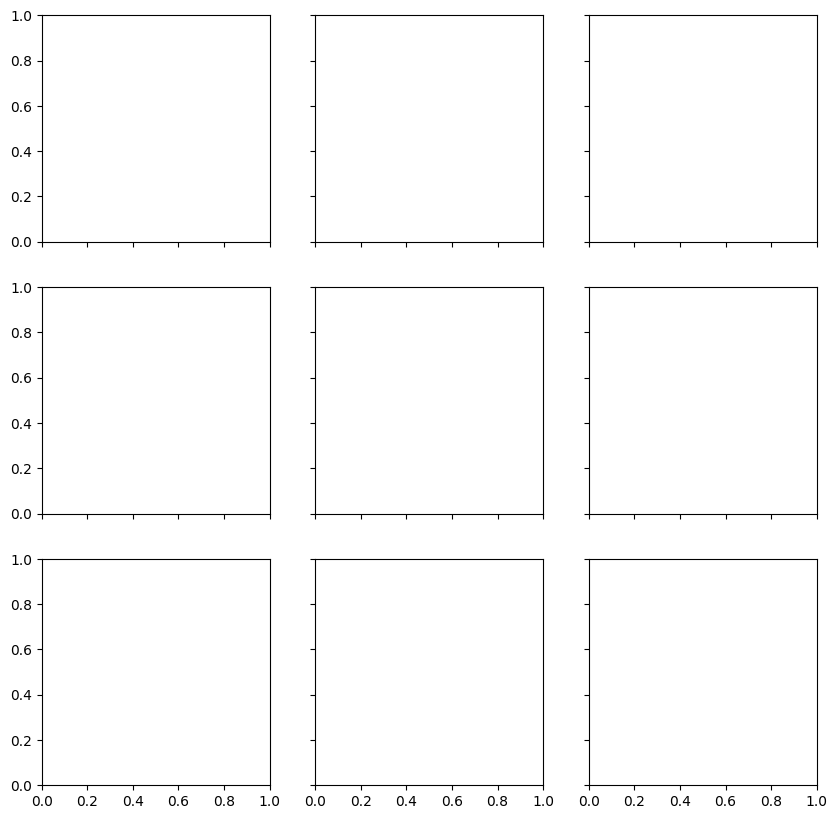

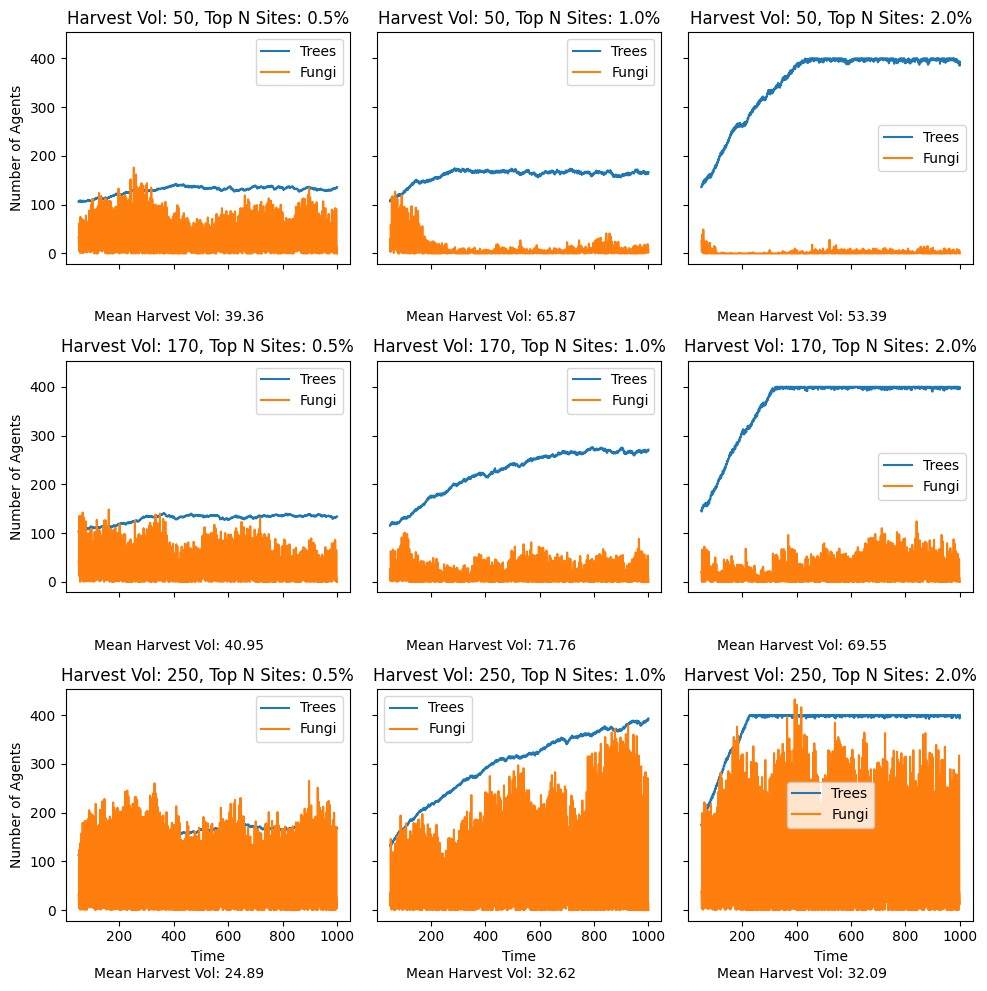

In [3]:
%matplotlib inline

width = 20
height = 20
n_init_trees = 100
n_init_fungi = 50
fert_comp_ratio_exponent = 0.5
top_n_sites_percent_values = [0.005, 0.01, 0.02]
harvest_volume_values = [50, 170, 250]
max_substrate=3
max_soil_fertility=1

# Initialize the model and run it for each combination of parameters
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)

for i, top_n_sites_percent in enumerate(top_n_sites_percent_values):
    for j, harvest_volume in enumerate(harvest_volume_values):
        # Update the harvest parameters
        harvest_params = [harvest_volume, 4, 0.5]
        
        # Create and run the model
        model = mdl.Forest(width, height, n_init_trees, n_init_fungi, harvest_params, fert_comp_ratio_exponent, 
                           max_substrate, max_soil_fertility, top_n_sites_percent)        
        model.run_model(n_steps=1000)
        
        # Collect the data
        data = model.datacollector.get_model_vars_dataframe()
        
        # Calculate the mean and standard deviation of harvested volume
        harvested_volume_mean = data["Harvested volume"].mean()
        # harvested_volume_std = data["Harvested volume"].std()
        
        # Plot the data starting from the 50th time step
        ax = axes[j, i]
        data[["Trees", "Fungi"]].iloc[50:].plot(ax=ax)
        ax.set_title(f'Harvest Vol: {harvest_volume}, Top N Sites: {top_n_sites_percent * 100}%')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Agents')
        
        # Print the mean and standard deviation below the plot
        textstr = '\n'.join((
            f'Mean Harvest Vol: {harvested_volume_mean:.2f}',
        ))
        ax.text(0.4, -0.2, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')

plt.tight_layout()
plt.show()